In [ ]:
# Install required packages
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.0 findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import findspark
findspark.init()

from datetime import datetime
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

print("Environment setup completed!")

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,595 kB]
Get:12 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get

In [ ]:
def create_spark_session():
    """Create and configure Spark session for Colab"""
    spark = SparkSession.builder \
        .appName("CancerClassification-Colab") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()

    spark.sparkContext.setLogLevel("WARN")

    print("Spark session created successfully!")
    print(f"Spark version: {spark.version}")
    return spark

# Initialize Spark
spark = create_spark_session()

Spark session created successfully!
Spark version: 3.5.0


In [ ]:
def create_sample_cancer_data(spark, num_samples=1000, num_features=200):
    """Create synthetic cancer dataset for demonstration"""
    from pyspark.ml.linalg import Vectors

    # Set random seed for reproducibility
    np.random.seed(42)

    # Create synthetic data
    data = []
    for i in range(num_samples):
        # Generate features (simulating gene expression data)
        features = np.random.normal(0, 1, num_features)

        # Create some meaningful patterns for classification
        # Samples with high values in first 50 features are more likely to be class 1
        risk_score = np.mean(features[:50]) + 0.5 * np.mean(features[50:100])
        label = 1 if risk_score > 0 else 0

        # Add some noise
        if np.random.random() < 0.1:  # 10% noise
            label = 1 - label

        data.append((float(label), Vectors.dense(features.astype(float))))

    # Create DataFrame
    columns = ["label", "features"]
    df = spark.createDataFrame(data, columns)

    return df

# Create sample dataset
print("Generating sample cancer dataset...")
sample_data = create_sample_cancer_data(spark, num_samples=1000, num_features=200)
print("Sample dataset created!")

Generating sample cancer dataset...
Sample dataset created!


=== DATASET EXPLORATION ===
Total samples: 1000
Number of features: 200

Class Distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  473|
|  1.0|  527|
+-----+-----+


Dataset Schema:
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)


Sample Records:
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

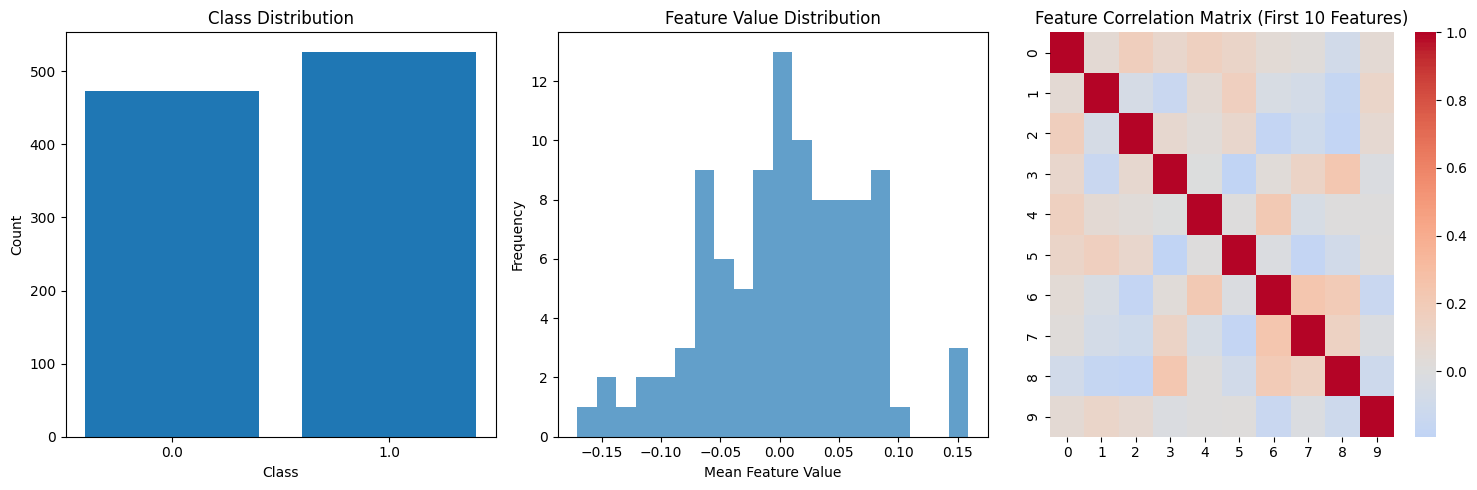

In [ ]:
def explore_dataset(dataset):
    """Explore the dataset characteristics"""
    print("=== DATASET EXPLORATION ===")

    # Basic info
    print(f"Total samples: {dataset.count()}")
    print(f"Number of features: {len(dataset.first().features)}")

    # Class distribution
    class_dist = dataset.groupBy("label").count().orderBy("label")
    print("\nClass Distribution:")
    class_dist.show()

    # Dataset schema
    print("\nDataset Schema:")
    dataset.printSchema()

    # Sample data
    print("\nSample Records:")
    dataset.show(5, truncate=False)

    # Convert to Pandas for visualization
    pandas_df = dataset.limit(100).toPandas()

    # Plot class distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    class_counts = dataset.groupBy("label").count().toPandas()
    plt.bar(class_counts['label'].astype(str), class_counts['count'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Plot feature statistics
    plt.subplot(1, 3, 2)
    feature_stats = pandas_df['features'].apply(lambda x: x.toArray().mean())
    plt.hist(feature_stats, bins=20, alpha=0.7)
    plt.title('Feature Value Distribution')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Frequency')

    # Plot feature correlations (first 10 features)
    plt.subplot(1, 3, 3)
    feature_matrix = np.array([x.toArray() for x in pandas_df['features']])
    corr_matrix = np.corrcoef(feature_matrix[:, :10], rowvar=False)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix (First 10 Features)')

    plt.tight_layout()
    plt.show()

    return pandas_df

# Explore the dataset
pandas_data = explore_dataset(sample_data)

In [ ]:
class CancerClassificationPipeline:
    def __init__(self, spark_session):
        self.spark = spark_session
        self.models = {}
        self.evaluations = {}

    def prepare_data(self, dataset, test_size=0.2):
        """Split data into training and testing sets"""
        train_data, test_data = dataset.randomSplit([1-test_size, test_size], seed=42)

        print(f"Training set: {train_data.count()} samples")
        print(f"Testing set: {test_data.count()} samples")

        return train_data, test_data

    def create_decision_tree_pipeline(self):
        """Create Decision Tree pipeline with hyperparameter tuning"""
        dt = DecisionTreeClassifier(
            labelCol="label",
            featuresCol="features",
            seed=42
        )

        param_grid = ParamGridBuilder() \
            .addGrid(dt.maxDepth, [5, 10, 15]) \
            .addGrid(dt.maxBins, [32, 64]) \
            .addGrid(dt.impurity, ["gini", "entropy"]) \
            .build()

        return dt, param_grid

    def create_random_forest_pipeline(self):
        """Create Random Forest pipeline"""
        rf = RandomForestClassifier(
            labelCol="label",
            featuresCol="features",
            seed=42
        )

        param_grid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [50, 100]) \
            .addGrid(rf.maxDepth, [5, 10]) \
            .addGrid(rf.maxBins, [32, 64]) \
            .build()

        return rf, param_grid

    def evaluate_model(self, model, test_data, model_name):
        """Comprehensive model evaluation"""
        predictions = model.transform(test_data)

        # Binary classification evaluator
        binary_evaluator = BinaryClassificationEvaluator(
            labelCol="label",
            rawPredictionCol="rawPrediction",
            metricName="areaUnderROC"
        )

        # Multiclass evaluators
        multi_evaluator_acc = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="accuracy"
        )

        multi_evaluator_f1 = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="f1"
        )

        # Calculate metrics
        auc = binary_evaluator.evaluate(predictions)
        accuracy = multi_evaluator_acc.evaluate(predictions)
        f1 = multi_evaluator_f1.evaluate(predictions)

        metrics = {
            'AUC': auc,
            'Accuracy': accuracy,
            'F1-Score': f1
        }

        print(f"\n=== {model_name.upper()} EVALUATION ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        # Store results
        self.evaluations[model_name] = {
            'metrics': metrics,
            'predictions': predictions
        }

        return predictions, metrics

    def train_models(self, train_data, test_data):
        """Train multiple models and compare performance"""
        print("Starting model training...")

        # Define models to train
        models_to_train = {
            'decision_tree': self.create_decision_tree_pipeline(),
            'random_forest': self.create_random_forest_pipeline()
        }

        # Binary evaluator for cross-validation
        evaluator = BinaryClassificationEvaluator(
            labelCol="label",
            rawPredictionCol="rawPrediction",
            metricName="areaUnderROC"
        )

        results = {}

        for model_name, (estimator, param_grid) in models_to_train.items():
            print(f"\n--- Training {model_name.replace('_', ' ').title()} ---")

            # Cross-validation
            cv = CrossValidator(
                estimator=estimator,
                estimatorParamMaps=param_grid,
                evaluator=evaluator,
                numFolds=5,
                seed=42,
                parallelism=4
            )

            # Train model
            cv_model = cv.fit(train_data)

            # Store best model
            self.models[model_name] = cv_model

            # Evaluate
            predictions, metrics = self.evaluate_model(cv_model, test_data, model_name)
            results[model_name] = metrics

            # Feature importance (if available)
            try:
                if hasattr(cv_model.bestModel, 'featureImportances'):
                    importance = cv_model.bestModel.featureImportances
                    print(f"Feature importance calculated for {model_name}")
            except:
                print(f"Feature importance not available for {model_name}")

        return results

    def plot_results(self):
        """Plot comparison of model performances"""
        if not self.evaluations:
            print("No evaluation results to plot!")
            return

        metrics_df = pd.DataFrame({
            model: eval_data['metrics']
            for model, eval_data in self.evaluations.items()
        }).T

        plt.figure(figsize=(12, 6))

        # Plot metrics comparison
        metrics_df.plot(kind='bar', figsize=(12, 6))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.xlabel('Models')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return metrics_df

# Initialize and run the pipeline
pipeline = CancerClassificationPipeline(spark)
train_data, test_data = pipeline.prepare_data(sample_data)
results = pipeline.train_models(train_data, test_data)

Training set: 818 samples
Testing set: 182 samples
Starting model training...

--- Training Decision Tree ---

=== DECISION_TREE EVALUATION ===
AUC: 0.5420
Accuracy: 0.5330
F1-Score: 0.5349
Feature importance calculated for decision_tree

--- Training Random Forest ---

=== RANDOM_FOREST EVALUATION ===
AUC: 0.7277
Accuracy: 0.7088
F1-Score: 0.6986
Feature importance calculated for random_forest


<Figure size 1200x600 with 0 Axes>

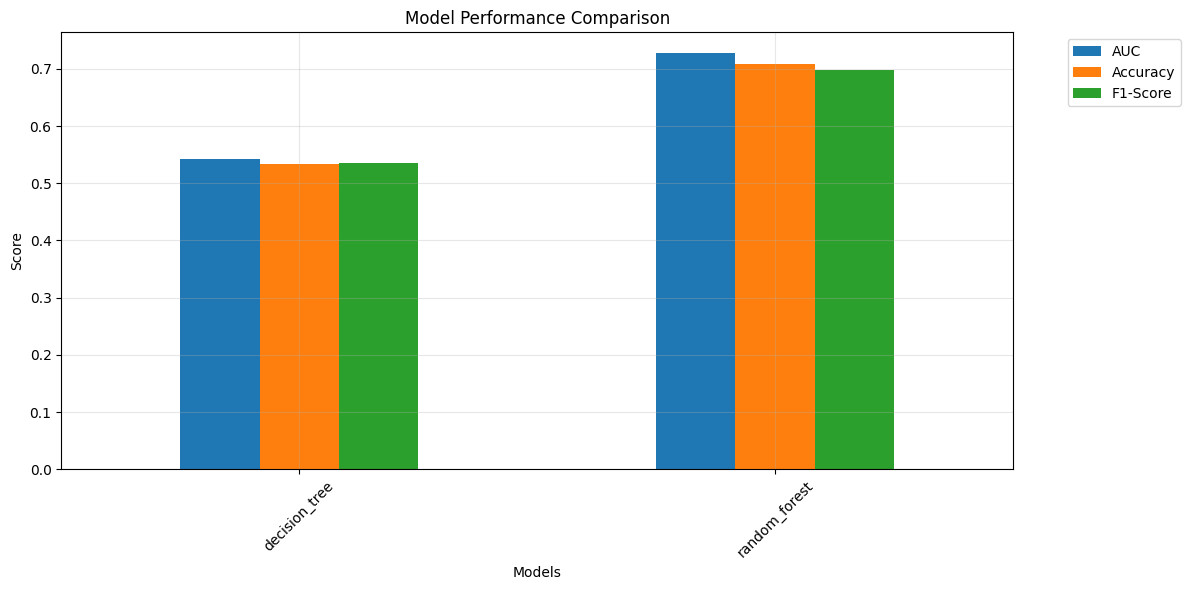


FINAL MODEL COMPARISON

DECISION TREE:
  AUC: 0.5420
  Accuracy: 0.5330
  F1-Score: 0.5349

RANDOM FOREST:
  AUC: 0.7277
  Accuracy: 0.7088
  F1-Score: 0.6986

🏆 BEST MODEL: Random Forest
📊 Best AUC Score: 0.7277


In [ ]:
# Plot results
metrics_comparison = pipeline.plot_results()

# Display detailed results
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

for model_name, metrics in results.items():
    print(f"\n{model_name.upper().replace('_', ' ')}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['AUC'])
print(f"\n🏆 BEST MODEL: {best_model[0].replace('_', ' ').title()}")
print(f"📊 Best AUC Score: {best_model[1]['AUC']:.4f}")


FEATURE IMPORTANCE ANALYSIS

Top 15 Features for Decision Tree:
   1. Feature   39: 0.0410
   2. Feature  150: 0.0376
   3. Feature    0: 0.0360
   4. Feature   18: 0.0340
   5. Feature   34: 0.0272
   6. Feature   35: 0.0269
   7. Feature   30: 0.0261
   8. Feature  117: 0.0223
   9. Feature   16: 0.0216
  10. Feature   17: 0.0192
  11. Feature  122: 0.0172
  12. Feature  196: 0.0170
  13. Feature   55: 0.0166
  14. Feature  126: 0.0157
  15. Feature  171: 0.0150


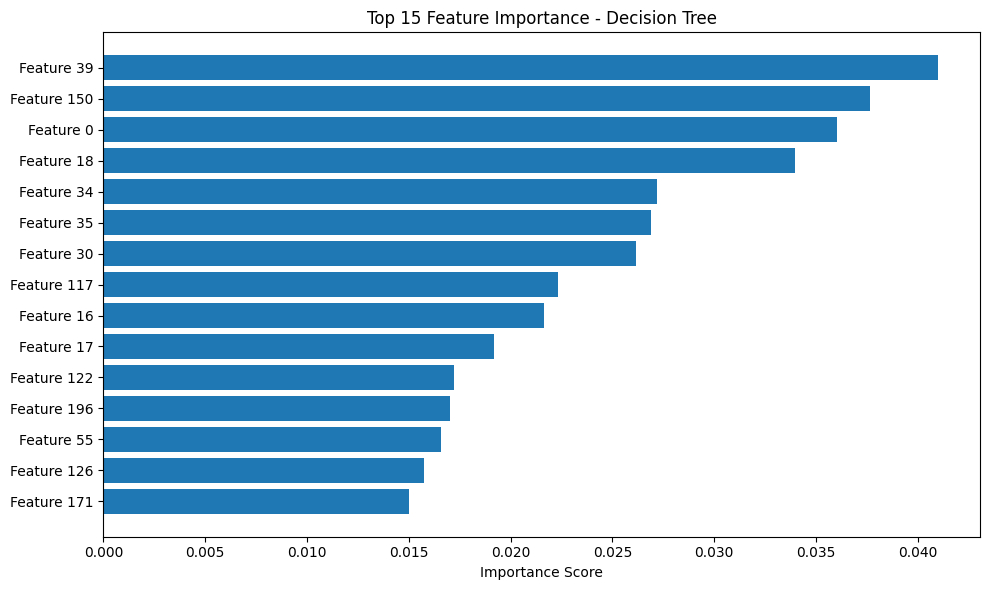


Top 15 Features for Random Forest:
   1. Feature   28: 0.0212
   2. Feature   26: 0.0206
   3. Feature   39: 0.0206
   4. Feature   19: 0.0168
   5. Feature   34: 0.0146
   6. Feature   32: 0.0140
   7. Feature  126: 0.0134
   8. Feature   48: 0.0130
   9. Feature    9: 0.0126
  10. Feature  161: 0.0125
  11. Feature   88: 0.0106
  12. Feature   85: 0.0098
  13. Feature   35: 0.0096
  14. Feature   46: 0.0095
  15. Feature   22: 0.0093


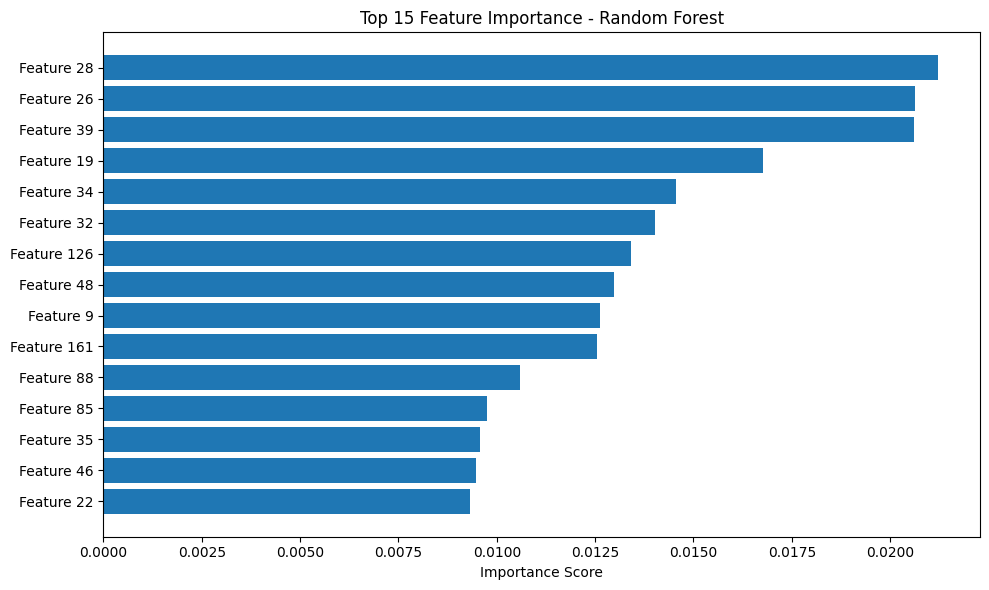

In [ ]:
def analyze_feature_importance(pipeline, top_n=15):
    """Analyze and visualize feature importance"""
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)

    for model_name, model in pipeline.models.items():
        try:
            if hasattr(model.bestModel, 'featureImportances'):
                importance = model.bestModel.featureImportances

                # Get top N important features
                feature_scores = [(i, score) for i, score in enumerate(importance)]
                top_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)[:top_n]

                print(f"\nTop {top_n} Features for {model_name.replace('_', ' ').title()}:")
                for idx, (feature_idx, score) in enumerate(top_features, 1):
                    print(f"  {idx:2d}. Feature {feature_idx:4d}: {score:.4f}")

                # Plot feature importance
                plt.figure(figsize=(10, 6))
                features, scores = zip(*top_features)
                plt.barh(range(len(features)), scores[::-1])
                plt.yticks(range(len(features)), [f'Feature {f}' for f in features[::-1]])
                plt.xlabel('Importance Score')
                plt.title(f'Top {top_n} Feature Importance - {model_name.replace("_", " ").title()}')
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Could not analyze feature importance for {model_name}: {e}")

# Analyze feature importance
analyze_feature_importance(pipeline)

In [ ]:
def show_predictions(pipeline, test_data, num_examples=10):
    """Show actual predictions with probabilities"""
    best_model_name = max(pipeline.evaluations.items(), key=lambda x: x[1]['metrics']['AUC'])[0]
    best_predictions = pipeline.evaluations[best_model_name]['predictions']

    print(f"\nPREDICTION EXAMPLES (using {best_model_name}):")
    print("="*60)

    # Define UDF to extract probability
    extract_prob = udf(lambda v: float(v[1]), DoubleType())

    prediction_samples = best_predictions.select(
        "label",
        "prediction",
        extract_prob("probability").alias("probability_1")
    ).limit(num_examples).toPandas()

    # Display with formatting
    for idx, row in prediction_samples.iterrows():
        actual = "Cancer" if row['label'] == 1 else "No Cancer"
        predicted = "Cancer" if row['prediction'] == 1 else "No Cancer"
        confidence = row['probability_1'] if row['prediction'] == 1 else 1 - row['probability_1']
        status = "✓" if row['label'] == row['prediction'] else "✗"

        print(f"Sample {idx+1:2d}: Actual: {actual:>10} | Predicted: {predicted:>10} | "
              f"Confidence: {confidence:.3f} {status}")

# Show prediction examples
show_predictions(pipeline, test_data)


PREDICTION EXAMPLES (using random_forest):
Sample  1: Actual:  No Cancer | Predicted:  No Cancer | Confidence: 0.517 ✓
Sample  2: Actual:  No Cancer | Predicted:  No Cancer | Confidence: 0.624 ✓
Sample  3: Actual:  No Cancer | Predicted:     Cancer | Confidence: 0.513 ✗
Sample  4: Actual:  No Cancer | Predicted:     Cancer | Confidence: 0.542 ✗
Sample  5: Actual:  No Cancer | Predicted:     Cancer | Confidence: 0.531 ✗
Sample  6: Actual:  No Cancer | Predicted:  No Cancer | Confidence: 0.540 ✓
Sample  7: Actual:  No Cancer | Predicted:  No Cancer | Confidence: 0.530 ✓
Sample  8: Actual:  No Cancer | Predicted:  No Cancer | Confidence: 0.505 ✓
Sample  9: Actual:  No Cancer | Predicted:     Cancer | Confidence: 0.552 ✗
Sample 10: Actual:  No Cancer | Predicted:     Cancer | Confidence: 0.518 ✗


In [ ]:
# Final summary
print("\n" + "="*70)
print("🎯 PIPELINE EXECUTION SUMMARY")
print("="*70)

total_samples = sample_data.count()
training_samples = train_data.count()
testing_samples = test_data.count()

print(f"📊 Dataset Statistics:")
print(f"   • Total samples: {total_samples}")
print(f"   • Training samples: {training_samples} ({training_samples/total_samples*100:.1f}%)")
print(f"   • Testing samples: {testing_samples} ({testing_samples/total_samples*100:.1f}%)")

print(f"\n🤖 Models Trained: {len(pipeline.models)}")
for model_name, metrics in results.items():
    print(f"   • {model_name.replace('_', ' ').title()}: AUC = {metrics['AUC']:.4f}")

best_overall = max(results.items(), key=lambda x: x[1]['AUC'])
print(f"\n🏆 Overall Best Performer:")
print(f"   • Model: {best_overall[0].replace('_', ' ').title()}")
print(f"   • AUC Score: {best_overall[1]['AUC']:.4f}")
print(f"   • Accuracy: {best_overall[1]['Accuracy']:.4f}")
print(f"   • F1-Score: {best_overall[1]['F1-Score']:.4f}")

print(f"\n✅ Pipeline execution completed successfully!")

# Optional: Stop Spark session (comment out if you want to continue working)
# spark.stop()


🎯 PIPELINE EXECUTION SUMMARY
📊 Dataset Statistics:
   • Total samples: 1000
   • Training samples: 818 (81.8%)
   • Testing samples: 182 (18.2%)

🤖 Models Trained: 2
   • Decision Tree: AUC = 0.5420
   • Random Forest: AUC = 0.7277

🏆 Overall Best Performer:
   • Model: Random Forest
   • AUC Score: 0.7277
   • Accuracy: 0.7088
   • F1-Score: 0.6986

✅ Pipeline execution completed successfully!
